(adaptive-tutorial)=
# Tutorial 4. Adaptive Measurements

```{seealso}
The complete source code of this tutorial can be found in

{nb-download}`Tutorial 4. Adaptive Measurements.ipynb`
```

This tutorial requires familiarity with the **core concepts** of Quantify.
We **highly recommended** to read the {ref}`user guide <user-guide>` and follow {ref}`Tutorial 1. Controlling a basic experiment using MeasurementControl` and {ref}`Tutorial 2. Advanced capabilities of the MeasurementControl` first.

In this tutorial, we explore the adaptive functionality of the {class}`.MeasurementControl`.
With this mode, instead of predefining a grid of values to sweep through, we provide an optimization function and an initial state to the `meas_ctrl`.
The `meas_ctrl` will then use this function to build the sweep. We import our usual modules and set up a `meas_ctrl` with visualization:

In [1]:
import time

import adaptive
import numpy as np
from qcodes import Instrument, ManualParameter
from scipy import optimize

import quantify_core.analysis.optimization_analysis as oa
import quantify_core.visualization.pyqt_plotmon as pqm
from quantify_core.analysis.interpolation_analysis import InterpolationAnalysis2D
from quantify_core.data.handling import set_datadir, default_datadir
from quantify_core.measurement.control import MeasurementControl
from quantify_core.visualization.instrument_monitor import InstrumentMonitor

Before instantiating any instruments or starting a measurement we change the
directory in which the experiments are saved using the
{meth}`~quantify_core.data.handling.set_datadir`
\[{meth}`~quantify_core.data.handling.get_datadir`\] functions.

----------------------------------------------------------------------------------------

⚠️ **Warning!**

We recommend always setting the directory at the start of the python kernel and stick
to a single common data directory for all notebooks/experiments within your
measurement setup/PC.

The cell below sets a default data directory (`~/quantify-data` on Linux/macOS or
`$env:USERPROFILE\\quantify-data` on Windows) for tutorial purposes. Change it to your
desired data directory. The utilities to find/search/extract data only work if
all the experiment containers are located within the same directory.

----------------------------------------------------------------------------------------

In [2]:
set_datadir('D:\HW\量子元件實驗室\Qblox\Qblox_datadir')

In [3]:
meas_ctrl = MeasurementControl("meas_ctrl")
insmon = InstrumentMonitor("InstrumentMonitor")
plotmon = pqm.PlotMonitor_pyqt("plotmon_meas_ctrl")
meas_ctrl.instr_plotmon(plotmon.name)

## Finding a minimum

We will create a mock Instrument our `meas_ctrl` will interact with. In this case, it is a simple parabola centered at the origin.

In [4]:
para = Instrument("parabola")

para.add_parameter("x", unit="m", label="X", parameter_class=ManualParameter)
para.add_parameter("y", unit="m", label="Y", parameter_class=ManualParameter)

para.add_parameter(
    "noise", unit="V", label="white noise amplitude", parameter_class=ManualParameter
)
para.add_parameter(
    "acq_delay", initial_value=0.1, unit="s", parameter_class=ManualParameter
)


def _amp_model():
    time.sleep(
        para.acq_delay()
    )  # for display purposes, just so we can watch the live plot update
    return para.x() ** 2 + para.y() ** 2 + para.noise() * np.random.rand(1)


para.add_parameter("amp", unit="V", label="Amplitude", get_cmd=_amp_model)

Next, we will use the `optimize` package from `scipy` to provide our adaptive function.
You can of course implement your own functions for this purpose, but for brevity we will use something standard and easily available.

Then, we set our {ref}`Settables and Gettables<Settables and Gettables>` as usual, and define a new dictionary `af_pars`.
The only required key in this object is `adaptive_function`, the value to be used by the adaptive function.
The remaining fields in this dictionary are the arguments to the adaptive function itself. We also add some noise into the parabola to stress our adaptive function.

**As such, it is highly recommended to thoroughly read the documentation around the adaptive function you are using.**

We will use the `optimize.minimize` function (note this is passed by reference as opposed to calling the `minimize` function), which requires an initial state named `"x0"` and an algorithm to use named `"method"`.
In this case, we are starting at `[-50, -50]` and hope to minimize these values relative to our parabola function.
Of course, this parabola has its global minimum at the origin, thus these values will tend towards 0 as our algorithm progresses.

In [5]:
meas_ctrl.settables([para.x, para.y])
af_pars = {
    "adaptive_function": optimize.minimize,  # used by meas_ctrl
    "x0": [-50, -50],  # used by `optimize.minimize` (in this case)
    "method": "Nelder-Mead",  # used by `optimize.minimize` (in this case)
    "options": {"maxfev": 100},  # limit the maximum evaluations of the gettable(s)
}
para.noise(0.5)
meas_ctrl.gettables(para.amp)
dset = meas_ctrl.run_adaptive("nelder_mead_optimization", af_pars)

Running adaptively...
.....................

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

.

In [6]:
dset

<xarray.Dataset>
Dimensions:  (dim_0: 100)
Coordinates:
    x0       (dim_0) float64 -50.0 -52.5 -50.0 ... 0.004735 0.004612 0.004737
    x1       (dim_0) float64 -50.0 -50.0 -52.5 ... -0.0008805 -0.0005568
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 5e+03 5.256e+03 5.257e+03 ... 0.3583 0.4199 0.08135
Attributes:
    tuid:                             20231121-130757-809-215edd
    name:                             nelder_mead_optimization
    grid_2d:                          False
    grid_2d_uniformly_spaced:         False
    1d_2_settables_uniformly_spaced:  False

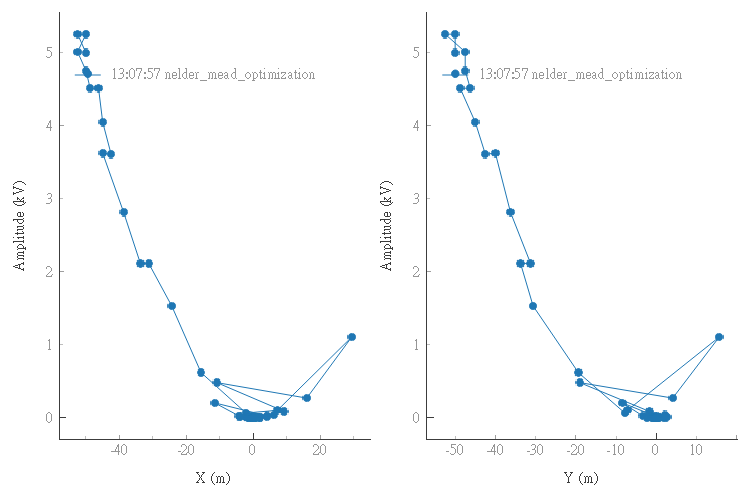

In [7]:
plotmon.main_QtPlot

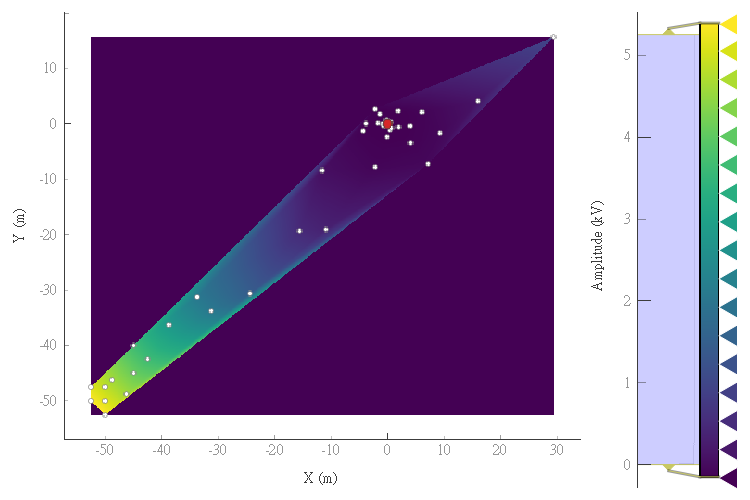

In [8]:
plotmon.secondary_QtPlot

We can see from the graphs that the values of the settables in the dataset snake towards 0 as expected. Success!

### Analysis

There are several analysis classes available in `quantify-core` that can be used to visualize and extract relevant information from the results of these adaptive measurements.

The {class}`~quantify_core.analysis.optimization_analysis.OptimizationAnalysis` class searches the dataset for the optimal datapoint and provides a number of useful plots to visualize the convergence of the measurement result around the minimum.

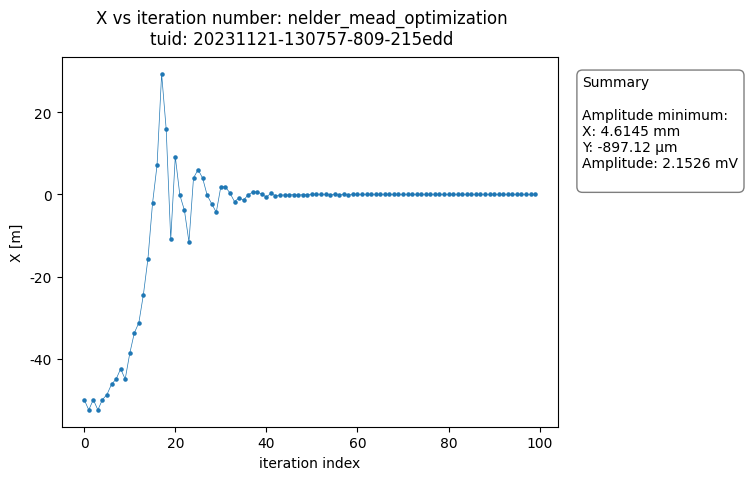

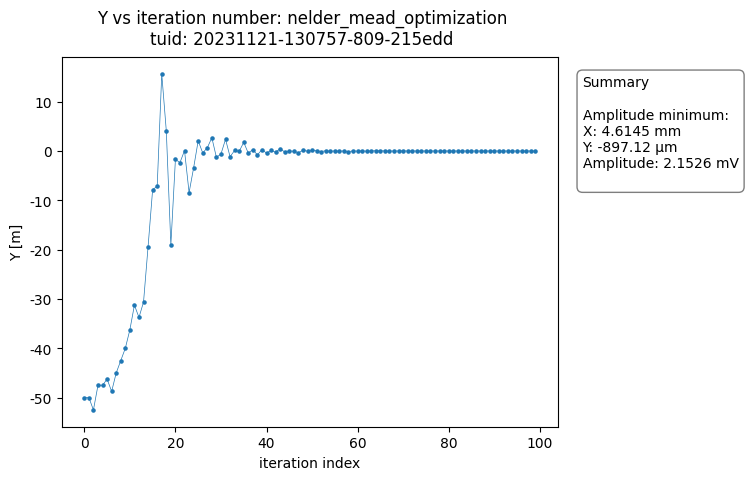

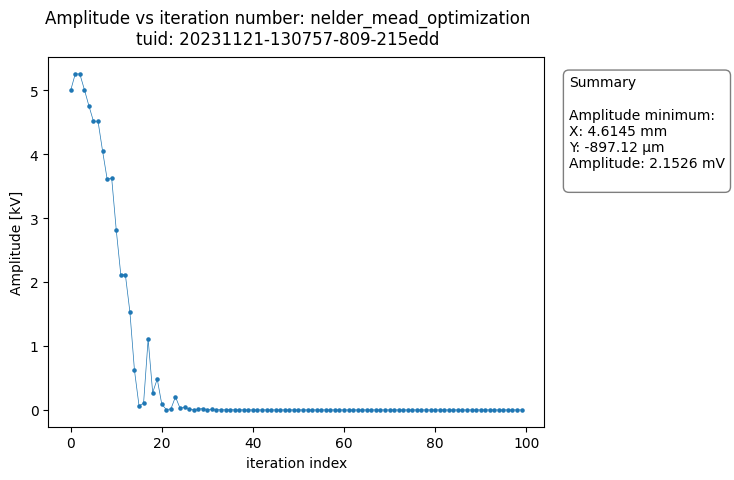

In [9]:
a_obj = oa.OptimizationAnalysis(dset)
a_obj.run()
a_obj.display_figs_mpl()

The analysis generates plots of each of the variables versus the number of iteration steps completed. The figures show the data converging on the optimal value.

The {class}`~quantify_core.analysis.interpolation_analysis.InterpolationAnalysis2D` class can be used to generate a 2-dimensional heatmap that interpolates between a set of irregularly spaced datapoints.

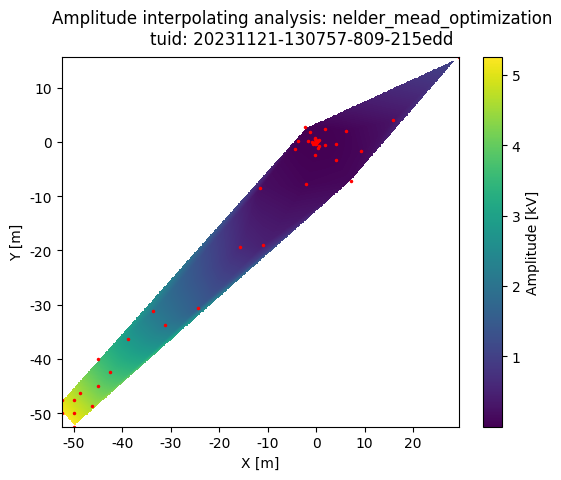

In [10]:
a_obj = InterpolationAnalysis2D(dset)
a_obj.run()
a_obj.display_figs_mpl()

## Adaptive Sampling

Quantify is designed to be modular and the adaptive functions support is no different. To this end, the `meas_ctrl` has first-class support for the `adaptive` package.
Let's see what the same experiment looks like with this module. Note the fields of the `af_pars` dictionary have changed to be compatible with the different adaptive functions that we are using.

As a practical example, let's revisit a Resonator Spectroscopy experiment. This time we only know our device has a resonance in 6-7 GHz range.
We really don't want to sweep through a million points, so instead let's use an adaptive sampler to quickly locate our peak.

In [11]:
res = Instrument("Resonator")

res.add_parameter("freq", unit="Hz", label="Frequency", parameter_class=ManualParameter)
res.add_parameter("amp", unit="V", label="Amplitude", parameter_class=ManualParameter)
_fwhm = 15e6  # pretend you don't know what this value is
_res_freq = 6.78e9  # pretend you don't know what this value is
_noise_level = 0.1


def lorenz():
    """A Lorenz model function."""
    time.sleep(0.02)  # for display purposes, just so we can watch the graph update
    return (
        1
        - (
            res.amp()
            * ((_fwhm / 2.0) ** 2)
            / ((res.freq() - _res_freq) ** 2 + (_fwhm / 2.0) ** 2)
        )
        + _noise_level * np.random.rand(1)
    )


res.add_parameter("S21", unit="V", label="Transmission amp. S21", get_cmd=lorenz)

In [12]:
_noise_level = 0.0
res.amp(1)
meas_ctrl.settables([res.freq])
af_pars = {
    "adaptive_function": adaptive.learner.Learner1D,
    "goal": lambda l: l.npoints > 99,
    "bounds": (6.0e9, 7.0e9),
}
meas_ctrl.gettables(res.S21)
dset = meas_ctrl.run_adaptive("adaptive sample", af_pars)

Running adaptively...
.......

.

.

.

In [13]:
dset

<xarray.Dataset>
Dimensions:  (dim_0: 100)
Coordinates:
    x0       (dim_0) float64 6e+09 7e+09 6.5e+09 ... 6.79e+09 6.77e+09 6.754e+09
Dimensions without coordinates: dim_0
Data variables:
    y0       (dim_0) float64 0.9999 0.9988 0.9993 ... 0.6186 0.6391 0.9237
Attributes:
    tuid:                             20231121-131857-686-c37a0e
    name:                             adaptive sample
    grid_2d:                          False
    grid_2d_uniformly_spaced:         False
    1d_2_settables_uniformly_spaced:  False

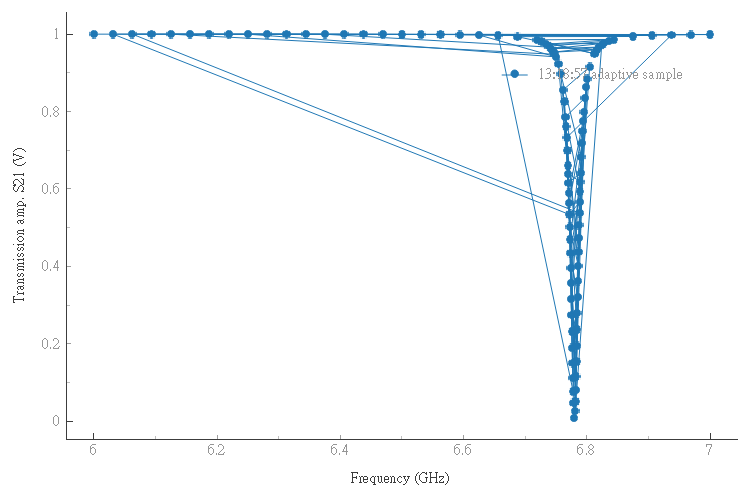

In [14]:
plotmon.main_QtPlot

## FAQ

### Can I return multi-dimensional data from a Gettable in Adaptive Mode?

Yes, but only the first dimension (`y0`) will be considered by the adaptive function;
the remaining dimensions will merely be saved to the dataset.